# How to work with a calibrated stereo camera

In [9]:
import cv2
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

## Load the Paramters

In [10]:
# in the dataset I have stored an example parameters file
param_path = './parameters.npz'

# the parameters are stored in a NPZ file
# you can import them to a dictionary and access the parameters
params = dict(np.load(param_path))
params.keys()

dict_keys(['Transformation', 'Essential', 'Fundamental', 'MeanError', 'SquareSize', 'BoardSize', 'Objpoints', 'L_Intrinsic', 'L_Distortion', 'L_DistortionROI', 'L_DistortionIntrinsic', 'L_RotVektor', 'L_RotMatrix', 'L_Extrinsics', 'L_TransVektor', 'L_Errors', 'L_MeanError', 'R_Intrinsic', 'R_Distortion', 'R_DistortionROI', 'R_DistortionIntrinsic', 'R_RotVektor', 'R_RotMatrix', 'R_Extrinsics', 'R_TransVektor', 'R_Errors', 'R_MeanError', 'L_Imgpoints', 'R_Imgpoints'])

## Epipolarlines

The *Epipolar Geometry* is the Geometry of a *Stereo Camera*. When two cameras look at the same point, they discribe a plane, the epipolar plane. With the known calibration parameters we can use this geometry to describe a point from one camera to the corresponding point on the other camera. More information about this can be found here: https://web.stanford.edu/class/cs231a/course_notes/03-epipolar-geometry.pdf 

In [11]:
# will be added later ...

## Rectification

Image rectification is a transformation process used to project images to a common image plane. It is used in computer vision to simplify the problem of finding matching points between images (correspondence problem). After a rectification of a stereocamera we have the same vertical coordinate of one point on both cameras. When you are interested in the calculation background you can have a look at (http://www.sci.utah.edu/~gerig/CS6320-S2013/Materials/CS6320-CV-F2012-Rectification.pdf).

In [12]:
# open an example image
pathL = '../data/data/imgs/leftcamera/Im_L_15.png'
imgL = cv2.imread(pathL,0)
imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
pathR = '../data/data/imgs/rightcamera/Im_R_15.png'
imgR = cv2.imread(pathR,0)
imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

In [13]:
# we will extract the necessary parameters for the calibration
K1,K2 = params['L_Intrinsic'], params['R_Intrinsic']
D1,D2 = params['L_Distortion'], params['R_Distortion']
ImageSize = (imgL.shape[1], imgL.shape[0])
Rk = params['Transformation'][:3,:3]
Tk = params['Transformation'][:3,3:]

In [15]:
# now we have to calculate the rectification maps
Rect = cv2.stereoRectify(K1,D1,K2,D2,ImageSize,Rk,Tk,alpha=0)
map1 = cv2.initUndistortRectifyMap(K1,D1,Rect[0],Rect[2],ImageSize,cv2.CV_32FC1)
map2 = cv2.initUndistortRectifyMap(K2,D2,Rect[1],Rect[3],ImageSize,cv2.CV_32FC1)

In [16]:
# with the maps we can rectify the images
imgL_rect = cv2.remap(imgL,map1[0],map1[1],cv2.INTER_AREA)
imgR_rect = cv2.remap(imgR,map2[0],map2[1],cv2.INTER_AREA)

After the calculation of the new rectified images we can display them. The top image pair is the original data and underneath the rectified ones. When you have a closer look at the solution you see that every point has the same vertical coordinate.

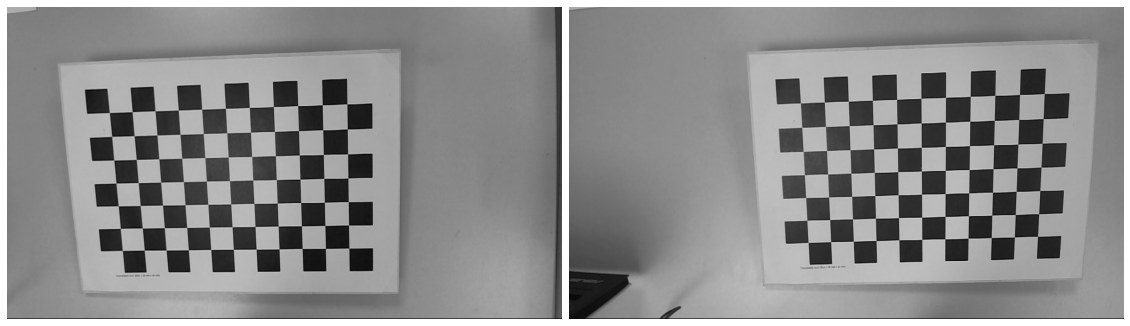

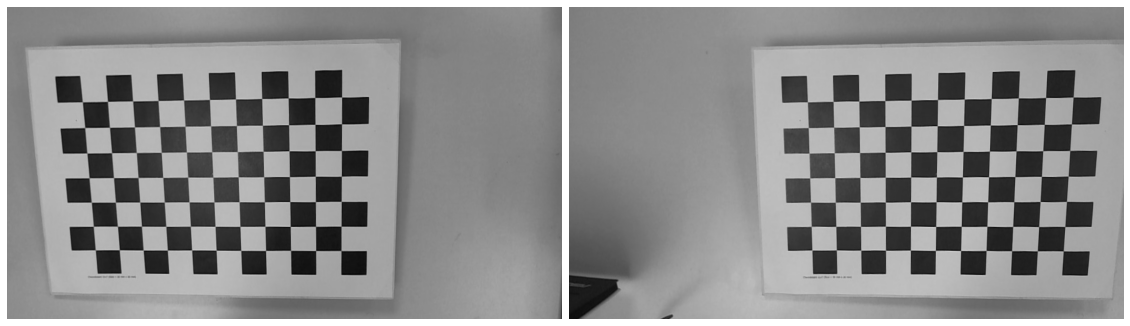

In [17]:
fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)
for ax, im in zip(grid, [imgL, imgR]):
    ax.imshow(im)
    ax.axis('off')

fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)
for ax, im in zip(grid, [imgL_rect, imgR_rect]):
    ax.imshow(im)
    ax.axis('off')

## Undistortion

In this section we are going to undistort an image. Therefore we need the distortion parameters from the calibration. Distortion must be seperated between radial and tangential distortion. To understand the difference and reading the parameters I recommmend to read the OpenCV documentation (https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html).

In [18]:
# so let's have a look to the parameters from the left camera.
params['L_Distortion']

array([[ 0.03202204, -0.17513664,  0.00090403,  0.0004851 ,  0.19902264]])

In [19]:
# open an example image
path = '../data/data/imgs/leftcamera/Im_L_15.png'
img = cv2.imread(path,0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [20]:
# undistort the image with the buildin function
img_undistorted = cv2.undistort(img, params['L_Intrinsic'], params['L_Distortion'], None, params['L_DistortionIntrinsic'])

Now we can display the undistorted image and compare it to the original picture. We cannot see any visible change, but that's because the camera is realy flat and there is no big distortion anyway. When you calibrate a fisheye camera (like a GoPro) you can see the differences clearly and the undistortion is a really nice feature for Computer Vision and working with Cameras.

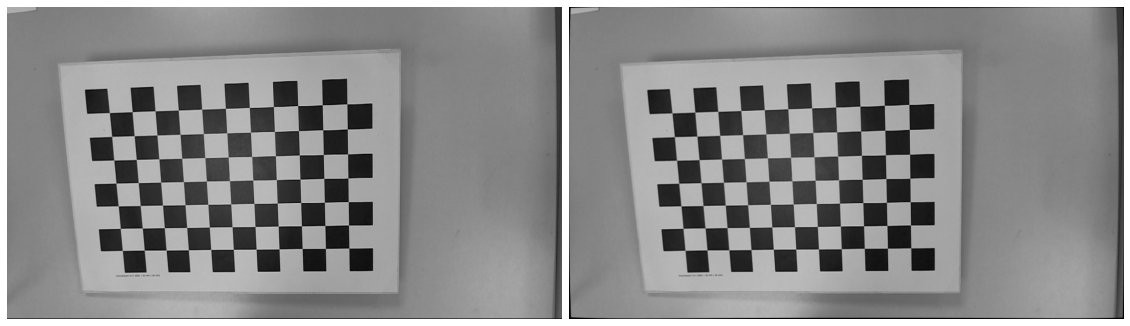

In [21]:
fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)
for ax, im in zip(grid, [img, img_undistorted]):
    ax.imshow(im)
    ax.axis('off')

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#51BC23;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            Upvoting is for free ;)
        </p>
    </div>

In [22]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
imgL_rect_gray=cv2.cvtColor(imgL_rect, cv2.COLOR_BGR2GRAY)
imgR_rect_gray=cv2.cvtColor(imgR_rect, cv2.COLOR_BGR2GRAY)
disparity = stereo.compute(imgL_rect_gray, imgR_rect_gray)
# disparity = stereo.compute(imgR_rect,imgL_rect)

In [23]:
points_3D = cv2.reprojectImageTo3D(disparity, Rect[4])

In [24]:
mask = disparity > disparity.min()

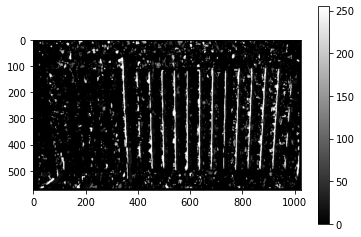

In [33]:
import matplotlib.pyplot as plt

# # Отображение карты глубины
# plt.imshow(mask, 'gray')
# plt.colorbar()
# plt.show()


disparity_normalized = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_normalized = np.uint8(disparity_normalized)

# # Отображение результатов
# cv2.imshow('Disparity', disparity_normalized)
# cv2.imshow('Depth Map', points_3D[:, :, 2])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.imshow(disparity_normalized, 'gray')
plt.colorbar()
plt.show()

In [28]:
min_disp = 0
num_disp = 16*5  # Это значение должно быть кратным 16
block_size = 5
stereo = cv2.StereoSGBM_create(minDisparity=min_disp,
                               numDisparities=num_disp,
                               blockSize=block_size,
                               P1=8*3*block_size**2,
                               P2=32*3*block_size**2,
                               disp12MaxDiff=1,
                               uniquenessRatio=15,
                               speckleWindowSize=100,
                               speckleRange=32,
                               preFilterCap=63,
                               mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)

In [30]:
# Вычисляем карту диспаратности
disparity = stereo.compute(imgL_rect, imgR_rect).astype(np.float32) / 16.0

# Преобразуем карту диспаратности в карту глубины
depth_map = cv2.reprojectImageTo3D(disparity, Q)

# Нормализация для отображения карты диспаратности
disparity_normalized = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_normalized = np.uint8(disparity_normalized)

# Отображение результатов
cv2.imshow('Disparity', disparity_normalized)
cv2.imshow('Depth Map', depth_map[:, :, 2])
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\stereobm.cpp:1173: error: (-210:Unsupported format or combination of formats) Both input images must have CV_8UC1 in function 'cv::StereoBMImpl::compute'
